# Sentiment Classifiers Binary:
#### This notebook contains various classifiers that can be used on a provided text dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
import keras
import sklearn
import csv
import itertools
import matplotlib.pyplot as plt
from sklearn import svm, datasets
import operator
import seaborn as sns
import pickle

D:\ProgramFiles\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramFiles\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramFiles\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramFiles\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
## This function is called by the classifiers to provide a visulization of the results
def plot_confusion_matrix(cm, classes, Y_test,
                          predictions,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print("Confusion Matrix:")
    print(cm)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    print(classification_report(Y_test, predictions, target_names = classes))

### Complete -> Enter the name of the dataset you want to test into the file_in variable:
##### The file_out dataset is the name of the dataset that will stored the number converted version of the text data. Set the name of file_out to the name of the converted dataset if you already have a dataset that has numeric representations of the dataset already instead of words. Otherwise, file_out will be the output file name that is the converted data of the file_in dataset that gets read in for classification for the tensorflow model. Also, if you already have a converted file, make sure that re_read is set to 0 so that it does not get overwritten.

In [3]:
### Enter filenames below:
file_in = "1-100.xlsx"
### Enter column names for data and labels below:
data_col = "review_body"
label_col = "tag"
### Set re_read to 0 if you already have a converted text file, 1 if it needs to be created
re_read = 0

In [4]:
df = pd.read_excel(file_in)
df = df[['review_body', 'tag']]
df = df.dropna()
df = df.reset_index()
df = df.drop(columns = ['index'])
print(file_in)
print(df.dtypes)
print("Sample size:", len(df))
print(df.head(5))

1-100.xlsx
review_body    object
tag             int64
dtype: object
Sample size: 100
                                         review_body  tag
0  My first really nice camera, and what a disapp...    1
1  While the camera initially functioned okay, it...    1
2  Its pretty simple folks; this thing produces a...    1
3  Very nice product. High quality and everything...    1
4  I have had this bag for a while and have used ...    1


#### Setting up the data.

In [5]:
X = df[data_col]
Y = df[label_col]

In [6]:
######## START CONVERSION: Convert data to POS tags
txt = nltk.word_tokenize(X[0])
print(txt)
txt = nltk.pos_tag(txt)
print(txt)
print()
print(txt[1][1])
print()
x_data = []
for i in range(len(txt)):
    x_data.append(txt[i][1])
txt = x_data
print(' '.join(txt))

['My', 'first', 'really', 'nice', 'camera', ',', 'and', 'what', 'a', 'disappointment', 'For', 'the', 'first', 'time', 'ever', 'in', 'my', 'life', ',', 'I', 'had', 'to', 'read', 'the', 'instruction', 'manual', 'to', 'figure', 'out', 'a', 'technical', 'item', '...', '(', 'a', 'first', 'for', 'someone', 'whos', 'built', 'telescopes', ',', 'configured/programmed/used', 'TVs', ',', 'VCRs', ',', 'stereo', 'component', 'systems', ',', 'MD', 'recorders', ',', 'camcorders', ',', 'and', 'used', 'many', 'cameras', 'without', 'the', 'aid', 'of', 'the', 'standard', 'booklet', ')', '.', 'Well', ',', 'theres', 'a', 'first', 'for', 'everything', 'That', 'is', 'fine', ',', 'but', '...', 'Embarassing', 'to', 'admit', ',', 'after', 'having', 'to', 'eventually', 'reread', 'the', 'manual', 'a', 'sum', 'of', 'about', 'FOUR', 'times', 'and', 'still', 'not', 'understanding', 'the', 'temperamental', 'nature', 'of', 'this', 'beast', '(', 'since', 'it', 'still', 'was', 'not', 'performing', 'as', 'predicted', 'in

In [7]:
X_pos = []
for i in range(len(df)):
    if (i % 1000 == 0):
        print("Update:", i) # Check spot in data converter process
    txt = nltk.word_tokenize(X[i])
    txt = nltk.pos_tag(txt)
    x_data = []
    for j in range(len(txt)):
        x_data.append(txt[j][1])
    txt = ' '.join(x_data)
    X_pos.append(txt)
X = X_pos
df[data_col] = X
######### END CONVERSTION

Update: 0


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.2, random_state=1, stratify=df[label_col])
print("Train data amount:", len(X_train))
print("Test data amount:", len(X_test))

Train data amount: 80
Test data amount: 20


In [9]:
### Stemming
# from nltk.stem import *
# stemmer = PorterStemmer()
# new_xtr2 = []
# new_xte2 = []
# for sent in X_train:
#     sent = nltk.word_tokenize(sent)
#     sent = [stemmer.stem(w) for w in sent]
#     sent = " ".join(sent)
#     new_xtr2.append(sent)
# X_train = new_xtr2
# for sent in X_test:
#     sent = nltk.word_tokenize(sent)
#     sent = [stemmer.stem(w) for w in sent]
#     sent = " ".join(sent)
#     new_xte2.append(sent)
# X_test = new_xte2
# all_data = X_train + X_test

## Logistic Regression Classifier:

In [10]:
#### Logistic Regression
text_clf_log = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-log', LogisticRegression(solver='liblinear')),
])

In [11]:
text_clf_log = text_clf_log.fit(X_train,Y_train)

In [12]:
predicted_log = text_clf_log.predict(X_test)
accuracy = np.mean(predicted_log == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_log)
print(cm)

Accuracy: 0.75
[[9 2]
 [3 6]]


Confusion Matrix:
[[9 2]
 [3 6]]


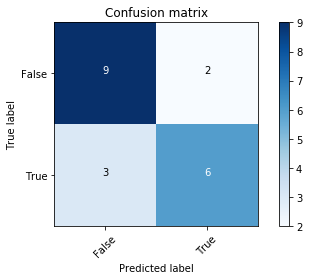

              precision    recall  f1-score   support

       False       0.75      0.82      0.78        11
        True       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



In [13]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_log)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_log,
                      title='Confusion matrix')

### Gridsearch: Logistic Regression

In [14]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              #'tfidf__use_idf': (True, False),
              'clf-log__C': (10, 1, 1e-1),
              'clf-log__solver': ('liblinear', 'newton-cg', 'lbfgs'),
    }

In [15]:
text_clf_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-log', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-log__C', 'clf-log__class_weight', 'clf-log__dual', 'clf-log__fit_intercept', 'clf-log__intercept_scaling', 'clf-log__l1_ratio', 'clf-log__max_iter', 'clf-log__multi_class', 'clf-log__n_jobs', 'clf-log__penalty', 'clf-log__random_state', 'clf-log__solver', 'clf-log__tol', 'clf-log__verbose', 'clf-log__warm_start'])

In [16]:
## Cross-validation and fit
gs_clf_log = GridSearchCV(text_clf_log, parameters, cv=5, n_jobs=-1)
gs_clf_log = gs_clf_log.fit(X_train,Y_train)
predicted_gs = gs_clf_log.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
print("Grid search best score:", gs_clf_log.best_score_)
print(gs_clf_log.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.7875
{'clf-log__C': 10, 'clf-log__solver': 'liblinear', 'vect__ngram_range': (1, 2)}
Accuracy: 0.7


Confusion Matrix:
[[6 5]
 [1 8]]


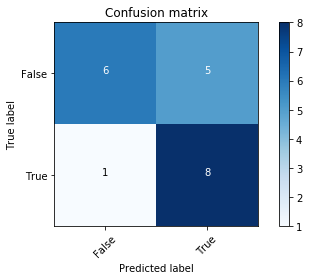

              precision    recall  f1-score   support

       False       0.86      0.55      0.67        11
        True       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



In [18]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Random Forest Classifier

In [19]:
#### Random Forest
text_clf_rfc = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-rfc', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)),
])

In [20]:
text_clf_rfc = text_clf_rfc.fit(X_train,Y_train)

In [21]:
predicted_rfc = text_clf_rfc.predict(X_test)
accuracy = np.mean(predicted_rfc == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_rfc)
print(cm)

Accuracy: 0.75
[[9 2]
 [3 6]]


Confusion Matrix:
[[9 2]
 [3 6]]


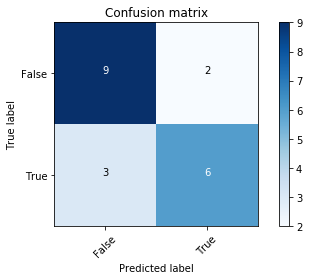

              precision    recall  f1-score   support

       False       0.75      0.82      0.78        11
        True       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



In [22]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_rfc)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_rfc,
                      title='Confusion matrix')

### Gridsearch: Random Forest

In [23]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              #'tfidf__use_idf': (True, False),
              'clf-rfc__max_depth': (2, 3, 4),
              'clf-rfc__criterion': ("gini", "entropy"),
              'clf-rfc__n_estimators': (100, 200, 300),
    }

In [24]:
text_clf_rfc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-rfc', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-rfc__bootstrap', 'clf-rfc__class_weight', 'clf-rfc__criterion', 'clf-rfc__max_depth', 'clf-rfc__max_features', 'clf-rfc__max_leaf_nodes', 'clf-rfc__min_impurity_decrease', 'clf-rfc__min_impurity_split', 'clf-rfc__min_samples_leaf', 'clf-rfc__min_samples_split', 'clf-rfc__min_weight_fraction_leaf', 'clf-rfc__n_estimators', 'clf-rfc__n_jobs', 'clf-rfc__oob_score', 'clf-rfc__random_state', 'clf-rfc__verbose', 'clf-rfc__warm_start'])

In [25]:
## Cross-validation and fit
gs_clf_rfc = GridSearchCV(text_clf_rfc, parameters, cv=5, n_jobs=-1)
gs_clf_rfc = gs_clf_rfc.fit(X_train,Y_train)
predicted_gs = gs_clf_rfc.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
print("Grid search best score:", gs_clf_rfc.best_score_)
print(gs_clf_rfc.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.7875
{'clf-rfc__criterion': 'entropy', 'clf-rfc__max_depth': 2, 'clf-rfc__n_estimators': 300, 'vect__ngram_range': (1, 2)}
Accuracy: 0.85


Confusion Matrix:
[[11  0]
 [ 3  6]]


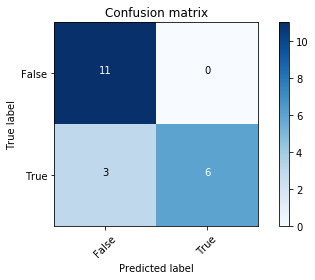

              precision    recall  f1-score   support

       False       0.79      1.00      0.88        11
        True       1.00      0.67      0.80         9

    accuracy                           0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20



In [27]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

In [28]:
gs_clf_rfc = GridSearchCV(text_clf_rfc, parameters, cv=5, n_jobs=-1)
gs_clf_rfc = gs_clf_rfc.fit(X_train,Y_train)
predicted_gs = gs_clf_rfc.predict_proba(X_test)
predicted_gs

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


array([[0.62243508, 0.37756492],
       [0.3999941 , 0.6000059 ],
       [0.58851948, 0.41148052],
       [0.18181595, 0.81818405],
       [0.63318048, 0.36681952],
       [0.53557871, 0.46442129],
       [0.82846495, 0.17153505],
       [0.71416333, 0.28583667],
       [0.32939194, 0.67060806],
       [0.51153851, 0.48846149],
       [0.7084329 , 0.2915671 ],
       [0.82846495, 0.17153505],
       [0.40610108, 0.59389892],
       [0.63015703, 0.36984297],
       [0.6637247 , 0.3362753 ],
       [0.29685687, 0.70314313],
       [0.42601994, 0.57398006],
       [0.58456035, 0.41543965],
       [0.71124609, 0.28875391],
       [0.5923829 , 0.4076171 ]])

In [29]:
file_in = "Tagged_Data_Values.csv"
df_unlabeled = pd.read_csv(file_in)
df_unlabeled = df_unlabeled[['review_body']]
df_unlabeled = df_unlabeled.dropna()
df_unlabeled = df_unlabeled[1000:2000]
df_unlabeled = df_unlabeled.reset_index()
df_unlabeled = df_unlabeled.drop(columns = ['index'])

print(file_in)
print(df_unlabeled.dtypes)
print("Sample size:", len(df))
print(df_unlabeled.head(5))

Tagged_Data_Values.csv
review_body    object
dtype: object
Sample size: 100
                                         review_body
0                Love it works awesome on my Sony A7
1  I would not to recommend to anybody to but the...
2  This bag has good cushioning and the insert in...
3  While this camera seems pretty good, please be...
4  This let me add 3 additional lens from an old ...


In [30]:
X_unlabeled = df_unlabeled[data_col]
X_unlabeled_pos = []
for i in range(len(df_unlabeled)):
    if (i % 1000 == 0):
        print("Update:", i) # Check spot in data converter process
    txt = nltk.word_tokenize(X_unlabeled[i])
    txt = nltk.pos_tag(txt)
    x_data = []
    for j in range(len(txt)):
        x_data.append(txt[j][1])
    txt = ' '.join(x_data)
    X_unlabeled_pos.append(txt)
X_unlabeled = X_unlabeled_pos
######### END CONVERSTION

Update: 0


In [31]:
len(X_unlabeled)

1000

In [32]:
predicted_gs = gs_clf_rfc.predict_proba(X_unlabeled)

In [33]:
to_be_labeled_index = []
index = 0
for proba in predicted_gs:
    if proba[0] > 0.4 and proba[0] < 0.6:
        to_be_labeled_index.append(index)
    index += 1
len(to_be_labeled_index)

357

In [34]:
to_be_labeled_index

[1,
 4,
 7,
 9,
 23,
 27,
 29,
 32,
 35,
 37,
 41,
 44,
 46,
 47,
 50,
 54,
 58,
 60,
 62,
 65,
 72,
 73,
 74,
 77,
 80,
 88,
 92,
 96,
 97,
 98,
 100,
 101,
 105,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 120,
 128,
 129,
 130,
 131,
 135,
 136,
 139,
 144,
 145,
 149,
 153,
 154,
 155,
 158,
 164,
 169,
 170,
 175,
 178,
 180,
 184,
 185,
 186,
 187,
 188,
 189,
 193,
 194,
 199,
 202,
 203,
 205,
 211,
 214,
 220,
 221,
 224,
 231,
 235,
 236,
 244,
 246,
 248,
 253,
 258,
 259,
 263,
 269,
 273,
 274,
 276,
 277,
 280,
 281,
 283,
 285,
 289,
 302,
 316,
 324,
 328,
 336,
 337,
 340,
 342,
 344,
 347,
 348,
 350,
 353,
 355,
 357,
 358,
 359,
 362,
 368,
 370,
 371,
 373,
 374,
 376,
 382,
 383,
 385,
 386,
 387,
 388,
 391,
 392,
 393,
 399,
 400,
 403,
 405,
 411,
 418,
 421,
 422,
 428,
 431,
 432,
 434,
 435,
 439,
 444,
 447,
 450,
 452,
 455,
 457,
 460,
 463,
 464,
 465,
 466,
 468,
 469,
 471,
 472,
 477,
 479,
 486,
 488,
 489,
 491,
 494,
 497,
 499,
 5

In [35]:
df_unlabeled = df_unlabeled.iloc[to_be_labeled_index,]

In [36]:
df_unlabeled.to_excel('proba_unlabeled.xlsx',index=False)

## Multinomial Naive Bayes classifier:

In [45]:
#### Multinomial Naive Bayes
text_clf_mnb = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-mnb', MultinomialNB()),
])

In [46]:
text_clf_mnb = text_clf_mnb.fit(X_train,Y_train)

In [47]:
predicted_mnb = text_clf_mnb.predict(X_test)
accuracy = np.mean(predicted_mnb == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_mnb)
print(cm)

Accuracy: 0.6
[[11  0]
 [ 8  1]]


Confusion Matrix:
[[11  0]
 [ 8  1]]


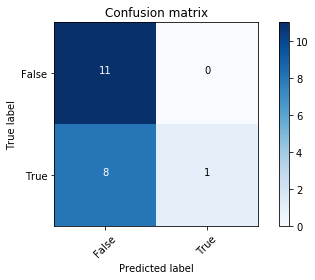

              precision    recall  f1-score   support

       False       0.58      1.00      0.73        11
        True       1.00      0.11      0.20         9

    accuracy                           0.60        20
   macro avg       0.79      0.56      0.47        20
weighted avg       0.77      0.60      0.49        20



In [48]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_mnb)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_mnb,
                      title='Confusion matrix')

### Gridsearch: Multinomial Naive Bayes

In [49]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf-mnb__alpha': (0, 1e-1, 1e-2),
    }

In [50]:
text_clf_mnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-mnb', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-mnb__alpha', 'clf-mnb__class_prior', 'clf-mnb__fit_prior'])

In [51]:
## Cross-validation and fit
gs_clf_mnb = GridSearchCV(text_clf_mnb, parameters, cv=5)
gs_clf_mnb = gs_clf_mnb.fit(X_train,Y_train)
predicted_gs = gs_clf_mnb.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors

In [52]:
print("Grid search best score:", gs_clf_mnb.best_score_)
print(gs_clf_mnb.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.675
{'clf-mnb__alpha': 0, 'vect__ngram_range': (1, 1)}
Accuracy: 0.8


Confusion Matrix:
[[11  0]
 [ 4  5]]


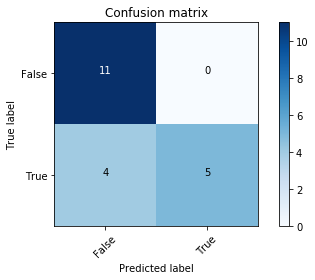

              precision    recall  f1-score   support

       False       0.73      1.00      0.85        11
        True       1.00      0.56      0.71         9

    accuracy                           0.80        20
   macro avg       0.87      0.78      0.78        20
weighted avg       0.85      0.80      0.79        20



In [53]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Complement Naive Bayes classifier:

In [54]:
#### Complement Naive Bayes
text_clf_cnb = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-cnb', ComplementNB()),
])

In [55]:
text_clf_cnb = text_clf_cnb.fit(X_train,Y_train)

In [56]:
predicted_cnb = text_clf_cnb.predict(X_test)
accuracy = np.mean(predicted_cnb == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_cnb)
print(cm)

Accuracy: 0.6
[[7 4]
 [4 5]]


Confusion Matrix:
[[7 4]
 [4 5]]


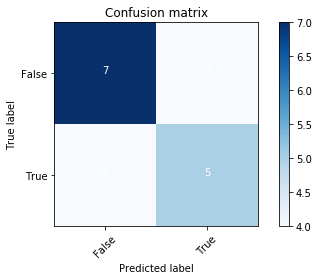

              precision    recall  f1-score   support

       False       0.64      0.64      0.64        11
        True       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



In [57]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_cnb)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_cnb,
                      title='Confusion matrix')

### Gridsearch: Complement Naive Bayes

In [58]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf-cnb__alpha': (0, 1e-1, 1e-2),
    }

In [59]:
text_clf_cnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-cnb', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-cnb__alpha', 'clf-cnb__class_prior', 'clf-cnb__fit_prior', 'clf-cnb__norm'])

In [60]:
## Cross-validation and fit
gs_clf_cnb = GridSearchCV(text_clf_cnb, parameters, cv=5)
gs_clf_cnb = gs_clf_cnb.fit(X_train,Y_train)
predicted_gs = gs_clf_cnb.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors

In [61]:
print("Grid search best score:", gs_clf_cnb.best_score_)
print(gs_clf_cnb.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.65
{'clf-cnb__alpha': 0, 'vect__ngram_range': (1, 1)}
Accuracy: 0.7


Confusion Matrix:
[[8 3]
 [3 6]]


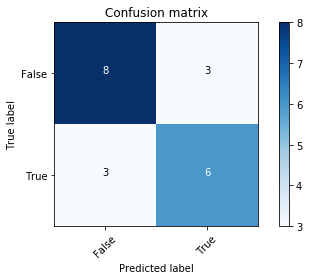

              precision    recall  f1-score   support

       False       0.73      0.73      0.73        11
        True       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



In [62]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## AdaBoost Classifier:

In [63]:
#### AdaBoost
text_clf_adb = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-adb', AdaBoostClassifier(learning_rate = 0.8, n_estimators = 170)),
])

In [64]:
text_clf_adb = text_clf_adb.fit(X_train,Y_train)

In [65]:
predicted_adb = text_clf_adb.predict(X_test)
accuracy = np.mean(predicted_adb == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_adb)
print(cm)

Accuracy: 0.75
[[10  1]
 [ 4  5]]


Confusion Matrix:
[[10  1]
 [ 4  5]]


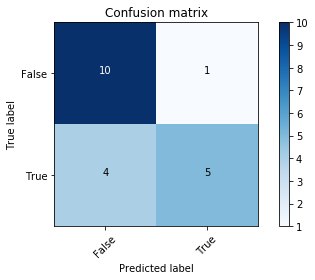

              precision    recall  f1-score   support

       False       0.71      0.91      0.80        11
        True       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



In [66]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_adb)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_adb,
                      title='Confusion matrix')

### Gridsearch: AdaBoost

In [67]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf-adb__n_estimators': (140, 160),
#               'clf-adb__learning_rate': (0.6, 0.8),
    }

In [68]:
text_clf_adb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-adb', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-adb__algorithm', 'clf-adb__base_estimator', 'clf-adb__learning_rate', 'clf-adb__n_estimators', 'clf-adb__random_state'])

In [69]:
## Cross-validation and fit
gs_clf_adb = GridSearchCV(text_clf_adb, parameters, cv=5)
gs_clf_adb = gs_clf_adb.fit(X_train,Y_train)
predicted_gs = gs_clf_adb.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [70]:
print("Grid search best score:", gs_clf_adb.best_score_)
print(gs_clf_adb.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.825
{'clf-adb__n_estimators': 160, 'vect__ngram_range': (1, 2)}
Accuracy: 0.8


Confusion Matrix:
[[10  1]
 [ 3  6]]


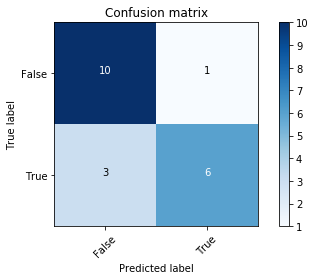

              precision    recall  f1-score   support

       False       0.77      0.91      0.83        11
        True       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20



In [71]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Gradient Boosting Classifier:

In [72]:
#### Gradient Boosting
text_clf_gdb = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf-gdb', AdaBoostClassifier(learning_rate = 0.9, n_estimators = 100)),
])

In [73]:
text_clf_gdb = text_clf_gdb.fit(X_train,Y_train)

In [74]:
predicted_gdb = text_clf_gdb.predict(X_test)
accuracy = np.mean(predicted_gdb == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_gdb)
print(cm)

Accuracy: 0.65
[[8 3]
 [4 5]]


Confusion Matrix:
[[8 3]
 [4 5]]


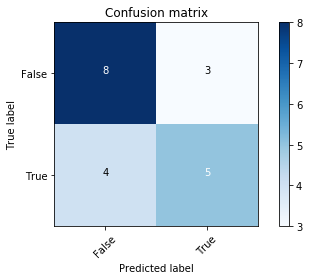

              precision    recall  f1-score   support

       False       0.67      0.73      0.70        11
        True       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



In [75]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gdb)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gdb,
                      title='Confusion matrix')

### Gridsearch: AdaBoost

In [76]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf-gdb__n_estimators': (100, 150),
#               'clf-adb__learning_rate': (0.7, 0.9),
    }

In [78]:
text_clf_gdb.get_params().keys()# a b c ab bc

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-gdb', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-gdb__algorithm', 'clf-gdb__base_estimator', 'clf-gdb__learning_rate', 'clf-gdb__n_estimators', 'clf-gdb__random_state'])

In [79]:
## Cross-validation and fit
gs_clf_gdb = GridSearchCV(text_clf_gdb, parameters, cv=5)
gs_clf_gdb = gs_clf_gdb.fit(X_train,Y_train)
predicted_gs = gs_clf_gdb.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [80]:
print("Grid search best score:", gs_clf_gdb.best_score_)
print(gs_clf_gdb.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.8125
{'clf-gdb__n_estimators': 100, 'vect__ngram_range': (1, 2)}
Accuracy: 0.75


Confusion Matrix:
[[10  1]
 [ 4  5]]


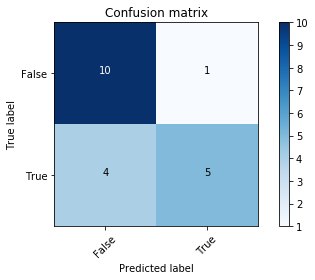

              precision    recall  f1-score   support

       False       0.71      0.91      0.80        11
        True       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



In [81]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Support Vector Machine classifier:

In [82]:
#### Support Vector Machine
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SVC(C=1.0, kernel='linear')), 
                    ])

In [83]:
text_clf_svm = text_clf_svm.fit(X_train,Y_train)

In [84]:
predicted_svm = text_clf_svm.predict(X_test)
accuracy = np.mean(predicted_svm == Y_test)
print("Accuracy:", accuracy)
cm = confusion_matrix(Y_test, predicted_svm)
print(cm)

Accuracy: 0.6
[[5 6]
 [2 7]]


Confusion Matrix:
[[5 6]
 [2 7]]


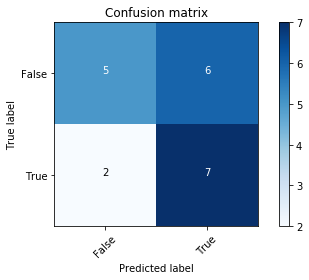

              precision    recall  f1-score   support

       False       0.71      0.45      0.56        11
        True       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



In [85]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_svm)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_svm,
                      title='Confusion matrix')

### Gridsearch: Support Vector Machine

In [86]:
#### Gridsearch
## To save time, do sigmoid with degree separately from other kernels
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              #'tfidf__use_idf': (True, False),
              'clf-svm__C': (10, 1, 1e-1),
    }

In [87]:
text_clf_svm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-svm', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-svm__C', 'clf-svm__cache_size', 'clf-svm__class_weight', 'clf-svm__coef0', 'clf-svm__decision_function_shape', 'clf-svm__degree', 'clf-svm__gamma', 'clf-svm__kernel', 'clf-svm__max_iter', 'clf-svm__probability', 'clf-svm__random_state', 'clf-svm__shrinking', 'clf-svm__tol', 'clf-svm__verbose'])

In [88]:
## Cross-validation and fit
gs_clf_svm = GridSearchCV(text_clf_svm, parameters, cv=5, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train,Y_train)
predicted_gs = gs_clf_svm.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [93]:
print("Grid search best score:", gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.8
{'clf-svm__C': 10, 'vect__ngram_range': (1, 1)}
Accuracy: 0.75


Confusion Matrix:
[[10  1]
 [ 4  5]]


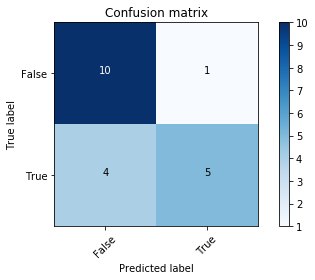

              precision    recall  f1-score   support

       False       0.71      0.91      0.80        11
        True       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



In [94]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')

## Stochastic Gradient Decent (SVM) classifier:

In [95]:
#### Stochastic Gradient Descent (SVM hinge loss) !!! STEMMING REDUCES 2% !!!
text_clf_sgd = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-sgd', SGDClassifier(loss='hinge', # modified_huber
                                                  penalty='l2',
                                                  max_iter=5,
                                                  random_state=42)), 
                    ])

In [96]:
_ = text_clf_sgd.fit(X_train,Y_train)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [97]:
predicted_sgd = text_clf_sgd.predict(X_test)
accuracy = np.mean(predicted_sgd == Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.55


Confusion Matrix:
[[11  0]
 [ 9  0]]


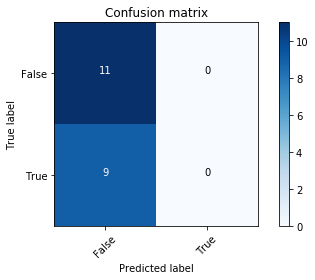

              precision    recall  f1-score   support

       False       0.55      1.00      0.71        11
        True       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_sgd)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_sgd,
                      title='Confusion matrix')

### Gridsearch: Stochastic Gradient Descent

In [99]:
#### Gridsearch
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
              'clf-sgd__alpha': (1e-2, 1e-3, 1e-4),
              'clf-sgd__l1_ratio': (0, 0.15, 1)
              #'clf-sgd__learning_rate': (1, 1e-1, 1e-2, 1e-3, 1e-4),
    }

In [100]:
text_clf_sgd.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf-sgd', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf-sgd__alpha', 'clf-sgd__average', 'clf-sgd__class_weight', 'clf-sgd__early_stopping', 'clf-sgd__epsilon', 'clf-sgd__eta0', 'clf-sgd__fit_intercept', 'clf-sgd__l1_ratio', 'clf-sgd__learning_rate', 'clf-sgd__loss', 'clf-sgd__max_iter', 'clf-sgd__n_iter_no_change', 'clf-sgd__n_jobs', 'clf-sgd__penalty', 'clf-sgd__power_t', 'clf-sgd__random_state', 'clf-sgd__shuffle', 'clf-sgd__tol', 'clf-sgd__validation_fraction', 'clf-sgd__verbose', 'clf-sgd__warm_start'])

In [101]:
## Cross-validation and fit
gs_clf_sgd = GridSearchCV(text_clf_sgd, parameters, cv=5)
gs_clf_sgd = gs_clf_sgd.fit(X_train,Y_train)
predicted_gs = gs_clf_sgd.predict(X_test)
accuracy = np.mean(predicted_gs == Y_test)

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yunkai\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve

In [103]:
print("Grid search best score:", gs_clf_sgd.best_score_)
print(gs_clf_sgd.best_params_)
print("Accuracy:", accuracy)

Grid search best score: 0.6375
{'clf-sgd__alpha': 0.0001, 'clf-sgd__l1_ratio': 0, 'vect__ngram_range': (1, 2)}
Accuracy: 0.7


Confusion Matrix:
[[5 6]
 [0 9]]


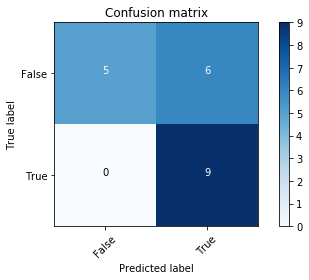

              precision    recall  f1-score   support

       False       1.00      0.45      0.62        11
        True       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



In [104]:
## Graphical visualization
cnf_matrix = confusion_matrix(Y_test, predicted_gs)
plt.figure()
class_names = ['False', 'True']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      Y_test = Y_test, predictions = predicted_gs,
                      title='Confusion matrix')